# Resources
- Jake VanderPlas' [Minimal code](http://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/)
- Bert Chan's [Google notebook](https://colab.research.google.com/github/OpenLenia/Lenia-Tutorial/blob/main/Tutorial_From_Conway_to_Lenia.ipynb#scrollTo=mbSw3-6lac1s)
- Computerfile explanation of [kernals](https://www.youtube.com/watch?v=C_zFhWdM4ic)

# Preparations

In [10]:
## IMPORTS ## 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
from scipy.signal import convolve2d

# For displaying animations in jupyter notebook
from matplotlib import rc
import IPython
from IPython.display import HTML, Image

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

## FUNCTIONS
def figure_world(A, cmap="viridis"):
    """Set up basic graphics of unpopulated, unsized world"""
    global img  # make final image global
    fig = plt.figure()  # Initiate figure
    img = plt.imshow(A, cmap=cmap, interpolation="nearest", vmin=0)  # Set image
    plt.title = ("World A")
    plt.close()
    return fig

# For as we begin producing more complex Kernels and growth functions
def figure_asset(K, growth, cmap="viridis", K_sum=1, bar_K=False):
    """Configures Graphical representations of input Kernel and growth function.
        The first plot on ax[0] demonstrates values of the Kernel across 0, 1, 2 columns
        ax[1] Gives cross section of the Kernel, ie. plots the values of row 1 (middle row of 3x3 kernel), around the target cell
        ax[2] Gives effect of Growth Kernel for different values of U. Negative or positive growth.
    """
    global R
    K_size = K.shape[0];
    K_mid = K_size // 2  # Get size and middle of Kernel
    fig, ax = plt.subplots(1, 3, figsize=(14, 2),
                           gridspec_kw={"width_ratios": [1, 1, 2]})  # Initiate figures with subplots

    ax[0].imshow(K, cmap=cmap, interpolation="nearest", vmin=0)
    ax[0].title.set_text("Kernel_K")

    if bar_K:
        ax[1].bar(range(K_size), K[K_mid, :], width=1)  # make bar plot
    else:
        ax[1].plot(range(K_size), K[K_mid, :])  # otherwise, plot normally
    ax[1].title.set_text("K cross-section")
    ax[1].set_xlim([K_mid - R - 3, K_mid + R + 3])

    if K_sum <= 1:
        x = np.linspace(0, K_sum, 1000)
        ax[2].plot(x, growth(x))
    else:
        x = np.arange(K_sum + 1)
        ax[2].step(x, growth(x))
    ax[2].axhline(y=0, color="grey", linestyle="dotted")
    ax[2].title.set_text("Growth G")
    return fig

def figure_asset_list(Ks, nKs, growth, kernels, use_c0=False, cmap='viridis', K_sum=1):
    global R
    K_size = Ks[0].shape[0];
    K_mid = K_size // 2
    fig, ax = plt.subplots(1, 3, figsize=(14, 2), gridspec_kw={'width_ratios': [1, 2, 2]})
    if use_c0:
        K_stack = [np.clip(np.zeros(Ks[0].shape) + sum(K / 3 for k, K in zip(kernels, Ks) if k['c0'] == l), 0, 1) for l
                   in range(3)]
    else:
        K_stack = Ks[:3]
    ax[0].imshow(np.dstack(K_stack), cmap=cmap, interpolation="nearest", vmin=0)
    ax[0].title.set_text('kernels Ks')
    X_stack = [K[K_mid, :] for K in nKs]
    ax[1].plot(range(K_size), np.asarray(X_stack).T)
    ax[1].title.set_text('Ks cross-sections')
    ax[1].set_xlim([K_mid - R - 3, K_mid + R + 3])
    x = np.linspace(0, K_sum, 1000)
    G_stack = [growth(x, k['m'], k['s']) * k['h'] for k in kernels]
    ax[2].plot(x, np.asarray(G_stack).T)
    ax[2].axhline(y=0, color='grey', linestyle='dotted')
    ax[2].title.set_text('growths Gs')
    return fig


# Modelling Obstacles
Formula's taken from the flowers lab, along with channel method illustrated below. 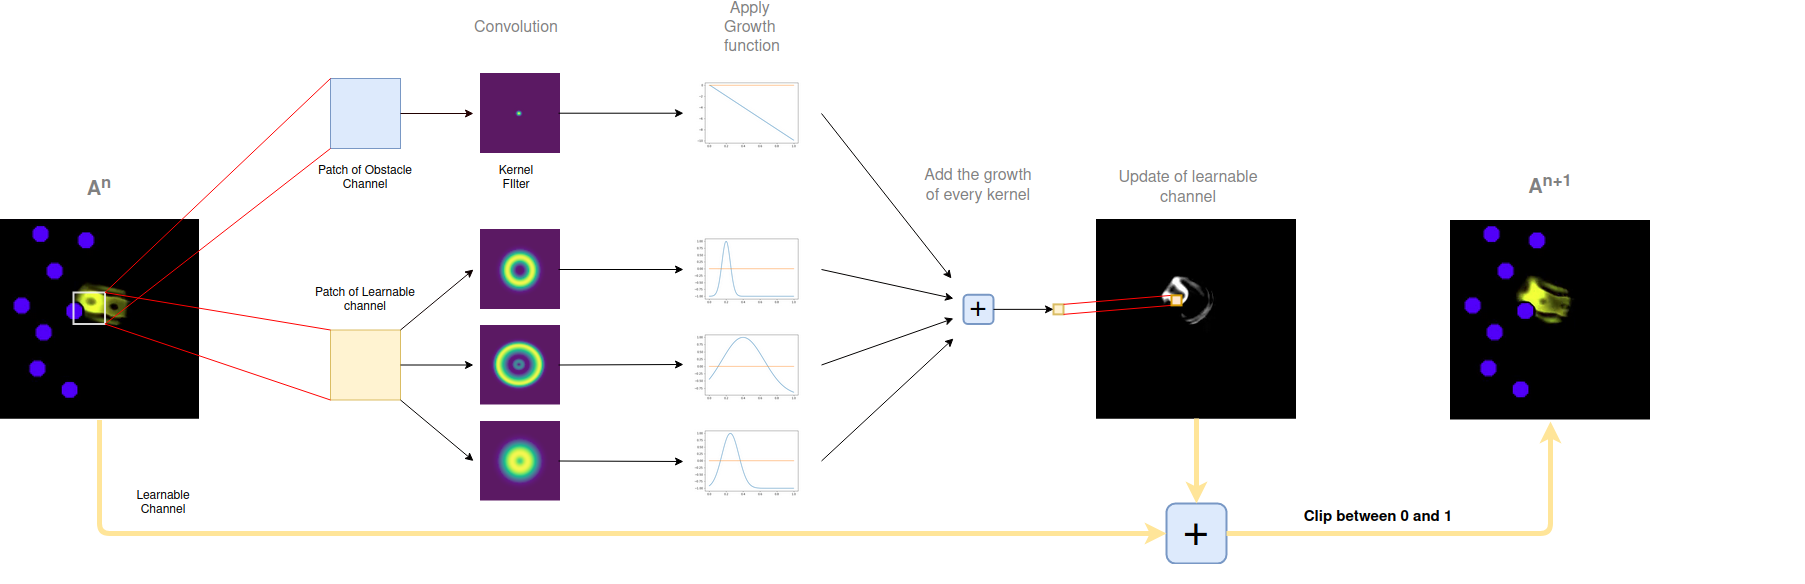

To start with, I modelled a simple Orbium in a single learning channel A. I then created a separate obstacle channel, which I populated with a solid square object of ones. The learning channel used a source kernel and growth function specified by Bert Chan's Orbium pattern above. Meanwhile, I modelled the kernel and growth function for the obstacle channel using the formlas below. 

Since obstacles only impact creatures on direct contact, I used the same distance matrix and specified only values of distance 0 (given transformations by radius, this roughly ended up being values > 0.05 distance from the cell).

$$
K_{obstacle} = x\rightarrow \exp({-\frac{(\frac{x}{2})^2}{2}})sigmoid(-10(\frac{x}{2}-1))
$$
- Equation above returns highest values for lowest values of X. Thus with input cells of a distance matrix, cells closest to target cell will have the lowest value (lowest distance from) and return highest values in the kernel. Meanwhile cells very far from the target cell will return lower impact in the kernel. 

$$
G_{obstacle} = x\rightarrow -10max(0, (x-0.001))
$$

$$
A^{t+1} = \large[A^t + \frac{1}{T}(G_{obstacle}(K_{obstacle}*A^t_1)+\Sigma h^kG^K(K_k*A^t_0)\large]^1_0
$$

Where $A_1$ is the obstacle channel, and $A_0$ is the learning channel. 

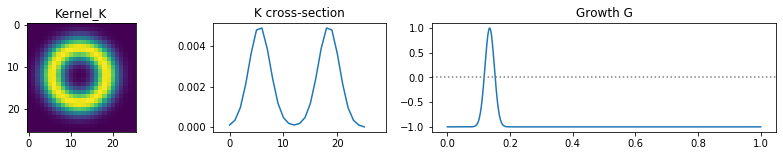

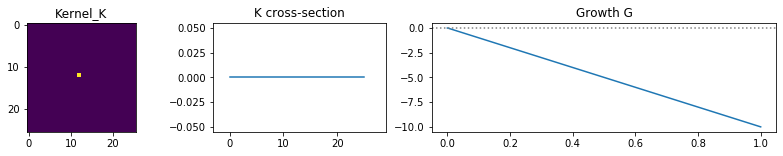

In [11]:
## SET UP ##
pattern = {}
pattern["orbium"] = {"name":"Orbium","R":13,"T":10,"m":0.15,"s":0.015,"b":[1],
"cells":[[0,0,0,0,0,0,0.1,0.14,0.1,0,0,0.03,0.03,0,0,0.3,0,0,0,0], [0,0,0,0,0,0.08,0.24,0.3,0.3,0.18,0.14,0.15,0.16,0.15,0.09,0.2,0,0,0,0], [0,0,0,0,0,0.15,0.34,0.44,0.46,0.38,0.18,0.14,0.11,0.13,0.19,0.18,0.45,0,0,0], [0,0,0,0,0.06,0.13,0.39,0.5,0.5,0.37,0.06,0,0,0,0.02,0.16,0.68,0,0,0], [0,0,0,0.11,0.17,0.17,0.33,0.4,0.38,0.28,0.14,0,0,0,0,0,0.18,0.42,0,0], [0,0,0.09,0.18,0.13,0.06,0.08,0.26,0.32,0.32,0.27,0,0,0,0,0,0,0.82,0,0], [0.27,0,0.16,0.12,0,0,0,0.25,0.38,0.44,0.45,0.34,0,0,0,0,0,0.22,0.17,0], [0,0.07,0.2,0.02,0,0,0,0.31,0.48,0.57,0.6,0.57,0,0,0,0,0,0,0.49,0], [0,0.59,0.19,0,0,0,0,0.2,0.57,0.69,0.76,0.76,0.49,0,0,0,0,0,0.36,0], [0,0.58,0.19,0,0,0,0,0,0.67,0.83,0.9,0.92,0.87,0.12,0,0,0,0,0.22,0.07], [0,0,0.46,0,0,0,0,0,0.7,0.93,1,1,1,0.61,0,0,0,0,0.18,0.11], [0,0,0.82,0,0,0,0,0,0.47,1,1,0.98,1,0.96,0.27,0,0,0,0.19,0.1], [0,0,0.46,0,0,0,0,0,0.25,1,1,0.84,0.92,0.97,0.54,0.14,0.04,0.1,0.21,0.05], [0,0,0,0.4,0,0,0,0,0.09,0.8,1,0.82,0.8,0.85,0.63,0.31,0.18,0.19,0.2,0.01], [0,0,0,0.36,0.1,0,0,0,0.05,0.54,0.86,0.79,0.74,0.72,0.6,0.39,0.28,0.24,0.13,0], [0,0,0,0.01,0.3,0.07,0,0,0.08,0.36,0.64,0.7,0.64,0.6,0.51,0.39,0.29,0.19,0.04,0], [0,0,0,0,0.1,0.24,0.14,0.1,0.15,0.29,0.45,0.53,0.52,0.46,0.4,0.31,0.21,0.08,0,0], [0,0,0,0,0,0.08,0.21,0.21,0.22,0.29,0.36,0.39,0.37,0.33,0.26,0.18,0.09,0,0,0], [0,0,0,0,0,0,0.03,0.13,0.19,0.22,0.24,0.24,0.23,0.18,0.13,0.05,0,0,0,0], [0,0,0,0,0,0,0,0,0.02,0.06,0.08,0.09,0.07,0.05,0.01,0,0,0,0,0]]
}
bell = lambda x, m, s: np.exp(-((x - m) / s) ** 2 / 2)  # Gaussian function
size = 64;
mid = size // 2;
scale = 0.75;
cx, cy = 20, 20

globals().update(pattern["orbium"])  # load orbium pattern
C = np.asarray(cells)


"""Load learning and obstacle channel"""
A = np.zeros([size, size])  # Initialise learning channel, A
A[cx:cx + C.shape[0], cy:cy + C.shape[1]] = C  # Load initial configurations into learning channel)

Ob = np.zeros([size, size])  # Initialise obstacle channel
Ob[35:45, 35:45] = 1  # Initialise obstacles
#Ob[40:45, 0:65] = 1  # Net: Gives single bar obstacle (ensure collision)

As = [A, Ob]  # List of channels

"""Create kernel for learning channel"""
D = np.linalg.norm(np.asarray(np.ogrid[-R:R, -R:R]) + 1) / R  # create distance matrix
K = (D < 1) * bell(D, 0.5, 0.15)  ## Transform all distances within radius 1 along smooth gaussian gradient
K = K / np.sum(K)  # Normalise between 0:1

"""Create obstacle kernel:
Take all distances == 0 (<0.05 given transformations to distance matrix above). 
Ie. Kernel only takes what is directly on the cell. Meanwhile kernel above senses
everything within 1 of the cell"""
sigmoid = lambda x: 1 / (1 + np.exp(-x))
obstacle_k = lambda x: np.exp(-((x / 2) ** 2) / 2) * sigmoid(-10 * (x / 2 - 1))
K_ob = (D < 0.05) * obstacle_k(D)


def growth(U):
    m = 0.135
    s = 0.015
    return bell(U, m, s) * 2 - 1


def obstacle_growth(U):
    return -10 * np.maximum(0, (U - 0.001))


def update(i):
    global As, img
    U1 = convolve2d(As[0], K, mode="same", boundary="wrap")
    U2 = convolve2d(As[1], K_ob, mode="same", boundary="wrap")
    # A = np.clip(A + 1/T*(growth(U1)), 0, 1)
    """Update learning channel with growth from both obstacle and 
    growth channel"""
    As[0] = np.clip(As[0] + 1 / T * (growth(U1) + obstacle_growth(U2)), 0, 1)
    img.set_array(sum(As))  # Sum two channels to create one channel
    return img,


figure_asset(K, growth)  # Learning kernel
figure_asset(K_ob, obstacle_growth)  # Obstacle kernel

np.random.seed(0)
fig = figure_world(sum(As))
IPython.display.HTML(animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

## Gradient of negative values
Expanding on the code above, I model a gradient of negative values simply by creating a channel of values that will be multiplied on by a negative growth function. Ie. Largest numbers have the most impact of negative growth and vice a versa. 

Since each cell is only weighted by the value of the cell, there is no need for kernel convolution to come to a neighbourhood sum. 

In [13]:
### GRADIENT OF NEGATIVE VALUES
    # Use exponential decay to populate grid of descending values
def exponential_gradient(gradient_stretch):
    """Create grid with exponentially descending values. 
    gradient_stretch lowers rate of descent to give a more diffuse
    gradient space."""
    x = np.exp(-np.arange(size)/gradient_stretch) # exp decay
    g = np.zeros([size, size])
    for i in range(size):
        g[i, ] = x[i]
    return g

gradient_channel = exponential_gradient(2)

As = [A, gradient_channel]

def growth(U):
    m = 0.135
    s = 0.015
    return bell(U, m, s) * 2 - 1

def update_gradient(i):
    global As, img
    U1 = convolve2d(As[0], K, mode="same", boundary="wrap")
    As[0] = np.clip(As[0] + 1/T*(growth(U1) + obstacle_growth(As[1])), 0, 1)
    img.set_array(sum(As))
    return img, 

np.random.seed(0)
fig = figure_world(sum(As))
IPython.display.HTML(animation.FuncAnimation(fig, update_gradient, frames=200, interval=20).to_jshtml())